In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce
from scipy.signal import argrelextrema

In [2]:
import sys
sys.path.append('../../')

In [3]:
from config.constants import *

In [4]:
plt.style.use('ggplot')

In [5]:
pairs_list = [
    'XAUUSD/XAUUSD_H4 - XAUUSD_H4',
]

In [6]:
df ={}
for pair in range(len(pairs_list)) :
    df[pair] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['H4'] + '.csv', index_col='Time',parse_dates=True)
    df[pair]['Day'] = df[pair].index.dayofweek
    dmap = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    df[pair]['Day'] = df[pair]['Day'].map(dmap)
    df[pair]['min'] = None
    df[pair]['max'] = None

In [7]:
def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return df

def CAGR(df, source_df):
    df = df.copy()
    n = len(source_df) / (252*24)
    return round((((df['cum_res'][-1] / account_size)**(1/n)) - 1) * 100, 1)

def sharpe_ratio(df):
    df = df.copy()
    returns = df['cum_res'].pct_change()
    volatility = returns.std() * np.sqrt(252)
    return round((returns.mean() - 0.02) / volatility, 2)

def max_drawdown(df):
    df = df.copy()
    cum_returns = (1 + df['cum_res']).cumprod()
    drawdown = 1 - df['cum_res'].div(df['cum_res'].cummax())
    return round(max(drawdown.expanding().max() * 100), 2)

In [8]:
#Strategy parameters
account_size = 10000
slippage = 2
size = 1
ATR_SL = 0.5

plot_trades = False

for pair in range(len(pairs_list)):
    df[pair]['ATR'] = ATR(df[pair], 20)['ATR']
    df[pair]['direction'] = np.where(df[pair]['Close'] > df[pair]['Open'], 'bull', 'bear')
    df[pair]['dir_count'] = df[pair].groupby((df[pair]['direction'] != df[pair]['direction'].shift(1)).cumsum()).cumcount()+1
    if 'JPY' not in pairs_list[pair]:
        df[pair]['spread'] = float(slippage) / float(10000)
        df[pair]['size'] = float(size) * float(10000)
        print('Pair: ', pairs_list[pair], 'a')
    else:
        df[pair]['spread'] = float(slippage) / float(100)
        df[pair]['size'] = float(size) * float(100)
        print('Pair: ', pairs_list[pair], 'b')

Pair:  XAUUSD/XAUUSD_H4 - XAUUSD_H4 a


In [9]:
for pair in range(len(pairs_list)):
    print('In', pairs_list[pair], 'dataframe is:', len(df[pair][df[pair]['direction'] == 'bull']), 'bullish candles and', 
         len(df[pair][df[pair]['direction'] == 'bear']), 'bearish candles')
    print('Maximum following candles of same direction is', max(df[pair]['dir_count']))
    print('Average number of following candles of same direction is', sum(df[pair]['dir_count']) / len(df[pair]['dir_count']))
    print(round(len(df[pair][df[pair]['dir_count'] == 1]) / len(df[pair]) * 100, 1), '% of the time market changed direction afte one candle \n')

In XAUUSD/XAUUSD_H4 - XAUUSD_H4 dataframe is: 13209 bullish candles and 12767 bearish candles
Maximum following candles of same direction is 11
Average number of following candles of same direction is 1.9068755774561132
51.5 % of the time market changed direction afte one candle 



In [10]:
def trade_plot(df, trade, exit_price, exit_date):
    plt.figure(figsize = (25, 8))
    plt.title(trade['signal'] + ' - With result: ' + str(round(trade['result'], 2)))
    plt.plot(df['Close'][(trade['date_of_trade'] - datetime.timedelta(days = 1000)): (trade['date_of_trade'] + datetime.timedelta(days = 30))], color = 'blue')
    plt.axhline(trade['TP'], color = 'green', ls = ':')
    plt.axhline(trade['SL'], color = 'red', ls = ':')
    plt.scatter(df.index, df['min'], color = 'red', s = 100)
    plt.scatter(df.index, df['max'], color = 'green', s = 100)
    plt.scatter(trade['date_of_trade'], trade['entry_price'], color = 'yellow', s = 200)
    plt.scatter(exit_date, exit_price, color = 'orange', s = 200)
    
    plt.show()

In [11]:
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}
size_multiplier = {}

for pair in range(len(pairs_list)):
    open_trade[pair] = []
    trade[pair] = {}
    long_take_profit[pair] = []
    short_take_profit[pair] = []
    long_stop_loss[pair] = []
    short_stop_loss[pair] = []
    long_entry_price[pair] = []
    short_entry_price[pair] = []
    
    size_multiplier[pair] = 1
    
    for i in range(50, len(df[pair])):
        #Buy
        if df[pair]['direction'][i - 1] == 'bear' and len(open_trade[pair]) == 0:
            print(i, 'New Long trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                              'date_of_trade': df[pair].index[i],
                              'day_of_trade': df[pair]['Day'][i],
                              'entry_price': df[pair]['Open'][i],
                              'signal': 'Buy',
                              'result': 0,
                              'TP': df[pair]['Open'][i] + df[pair]['ATR'].mean(),
                              'SL': df[pair]['Open'][i] - df[pair]['ATR'].mean()}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
        
        #Sell
        if df[pair]['direction'][i - 1] == 'bull' and len(open_trade[pair]) == 0:
            print(i, 'New Short trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                              'date_of_trade': df[pair].index[i],
                              'day_of_trade': df[pair]['Day'][i],
                              'entry_price': df[pair]['Open'][i],
                              'signal': 'Sell',
                              'result': 0,
                              'TP': df[pair]['Open'][i] - df[pair]['ATR'].mean(),
                              'SL': df[pair]['Open'][i] + df[pair]['ATR'].mean()}
            open_trade[pair].append(i)
            short_take_profit[pair].append(trade[pair][i]['TP'])
            short_stop_loss[pair].append(trade[pair][i]['SL'])
            short_entry_price[pair].append(trade[pair][i]['entry_price'])
            
        #Exit trades---------------------------------------------------------------------------
        #Buy profit
        if any(y <= df[pair]['Close'][i] for y in long_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] >= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['TP'] - trade[pair][j]['entry_price']) * size_multiplier[pair] * df[pair]['size'][i]\
                                              - df[pair]['spread'][i]})
                        print(j, 
                             'Long profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                        size_multiplier[pair] = 1
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])
        #Buy loss
        if any(y >= df[pair]['Close'][i] for y in long_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] <= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['SL'] - trade[pair][j]['entry_price']) * size_multiplier[pair] * df[pair]['size'][i]\
                                              - df[pair]['spread'][i]})
                        print(j, 
                             'Long loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                        size_multiplier[pair] = size_multiplier[pair] * 2
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])
                        
        #Sell profit
        if any(y >= df[pair]['Close'][i] for y in short_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] <= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['TP']) * size_multiplier[pair] * df[pair]['size'][i]\
                                              - df[pair]['spread'][i]})
                        print(j, 
                             'Short profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
                        size_multiplier[pair] = 1
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])
        #Sell loss
        if any(y <= df[pair]['Close'][i] for y in short_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] >= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['SL']) * size_multiplier[pair] * df[pair]['size'][i]\
                                              - df[pair]['spread'][i]})
                        print(j, 
                             'Short loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
                        size_multiplier[pair] = size_multiplier[pair] * 2
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])

50 New Long trade at price: 611.489  On day: 2007-01-11 04:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
50 Long profit at price: 617.046 On day: 2007-01-12 12:00:00 With profit: 73840.7521 

59 New Short trade at price: 625.864  On day: 2007-01-12 16:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
59 Short loss at price: 625.864 On day: 2007-01-12 16:00:00 With loss: -73840.7525 

60 New Short trade at price: 626.233  On day: 2007-01-12 20:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
60 Short loss at price: 634.537 On day: 2007-01-19 16:00:00 With loss: -147681.5047 

91 New Short trade at price: 634.771  On day: 2007-01-19 20:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
91 Short loss at price: 644.792 On day: 2007-01-23 12:00:00 With loss: -295363.0093 

103 New Short trade at price: 647.117  On day: 2007-01-23 16:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
103 Short loss at price: 652.907 On day: 2007-01-31 12:00:00 With loss: -590726.0184 

140 New Short trade at price: 652.583  On day: 2007-01-31 16:00:

2626 Long loss at price: 794.678 On day: 2008-08-14 20:00:00 With loss: -73840.7525 

2628 New Long trade at price: 796.665  On day: 2008-08-15 00:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
2628 Long loss at price: 785.811 On day: 2008-08-15 12:00:00 With loss: -147681.5047 

2632 New Long trade at price: 786.706  On day: 2008-08-15 16:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
2632 Long profit at price: 798.964 On day: 2008-08-18 00:00:00 With profit: 295363.0089 

2636 New Short trade at price: 799.114  On day: 2008-08-18 04:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
2636 Short profit at price: 790.066 On day: 2008-08-18 08:00:00 With profit: 73840.7521 

2638 New Long trade at price: 798.596  On day: 2008-08-18 12:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
2638 Long profit at price: 798.596 On day: 2008-08-18 12:00:00 With profit: 73840.7521 

2639 New Short trade at price: 799.058  On day: 2008-08-18 16:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
2639 Short profit at price: 788.802 On day: 20

In [12]:
pairs_results = {}
profits = {}
losses = {}
be = {}

for pair in range(len(pairs_list)):
    profits[pair] = []
    losses[pair] = []
    be[pair] = []
    
    pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
    pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
    pairs_results[pair].set_index('date_of_trade', inplace = True)
    pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + account_size
    
    for t in trade[pair]:
        profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.1 else ''
        losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.1 else ''
        be[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.1 else ''
        
my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
strategy_results = reduce(my_reduce, pairs_results.values())
strategy_results = strategy_results.sort_index()
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))

Text(0.5, 1.0, 'Returns of each pair')

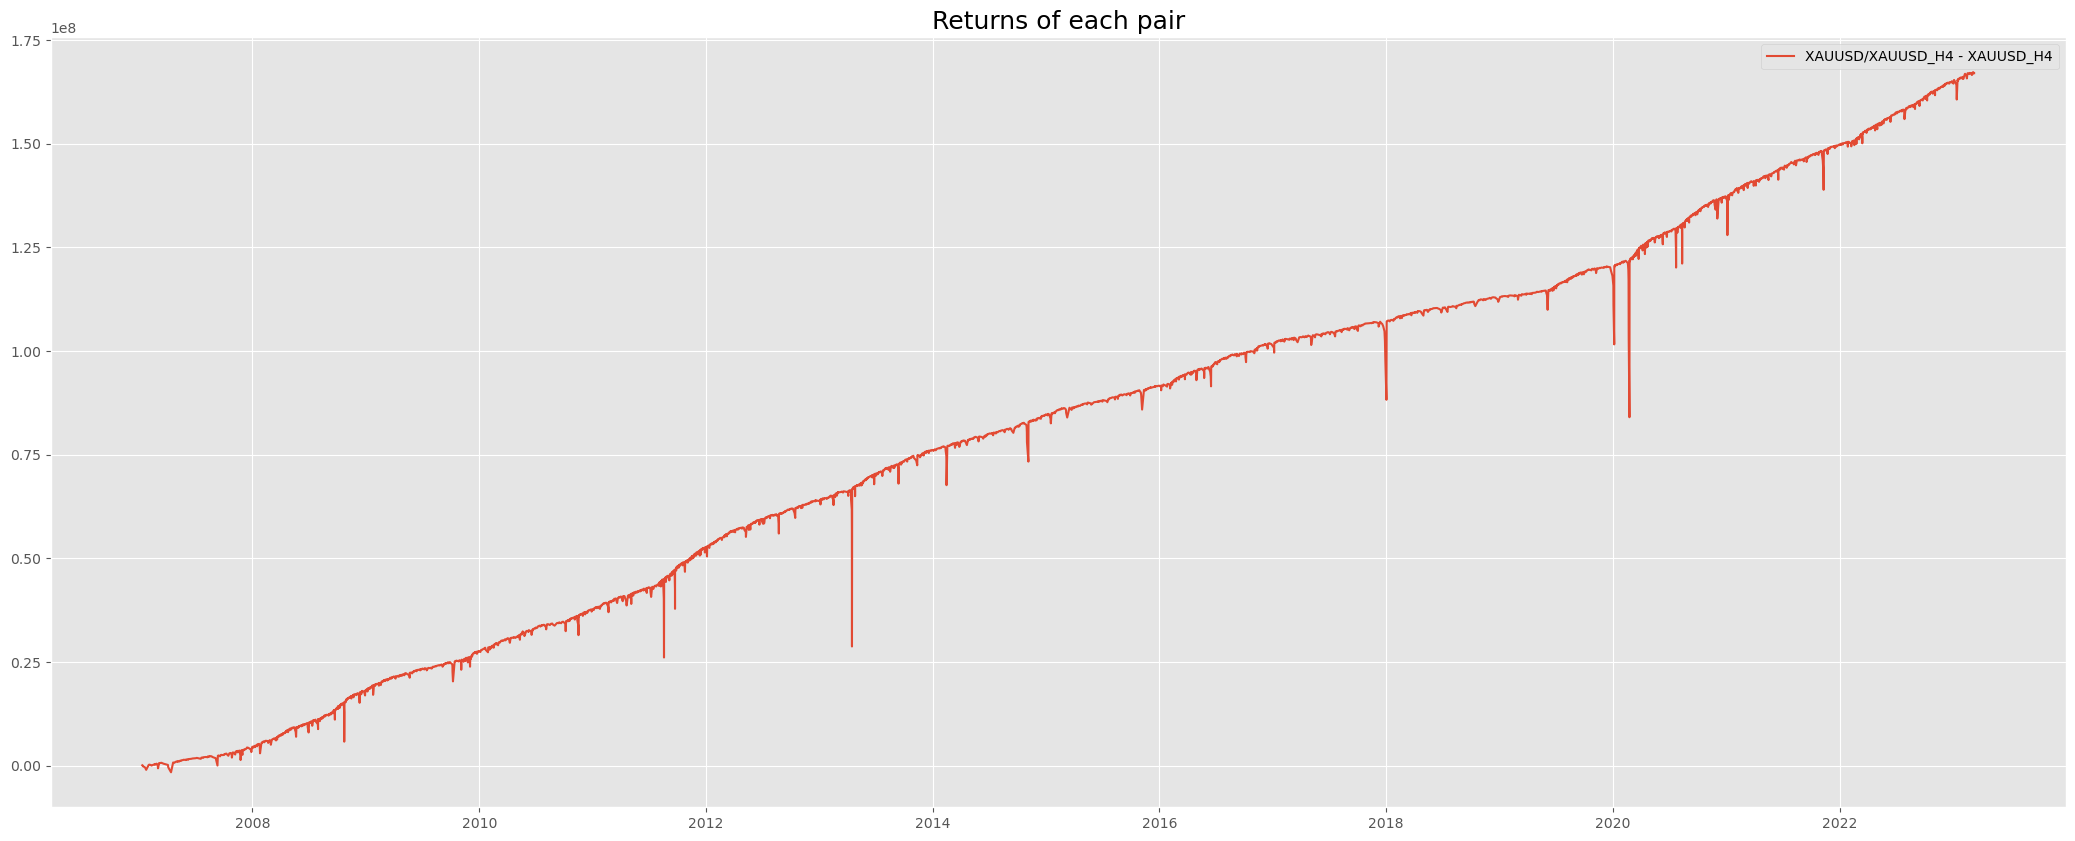

In [13]:
plt.figure(figsize = (26, 10))
for pair in range(len(pairs_list)):
    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair])
plt.legend()
plt.title('Returns of each pair', fontsize = 18)

***** STRATEGY PERFORMANCE *****
--------------------------------
CAGR: 862.1 %
Sharpe ratio: 0.0
Maximum drawdown 1321.09 % 

Number of trades: 4532
Number of profits: 2265
Number of losses: 2266
Number of breakevens: 1 

Winning percentage 49.99 %
ROI: 167027781
--------------------------------
Average profitable trade: 345535.6
Average lossing trade: -271672.71
Max profitable trade: 37806465.16
Max lossing trade: -18903232.58


c:\Users\Win10\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Text(0.5, 1.0, 'return of strategy')

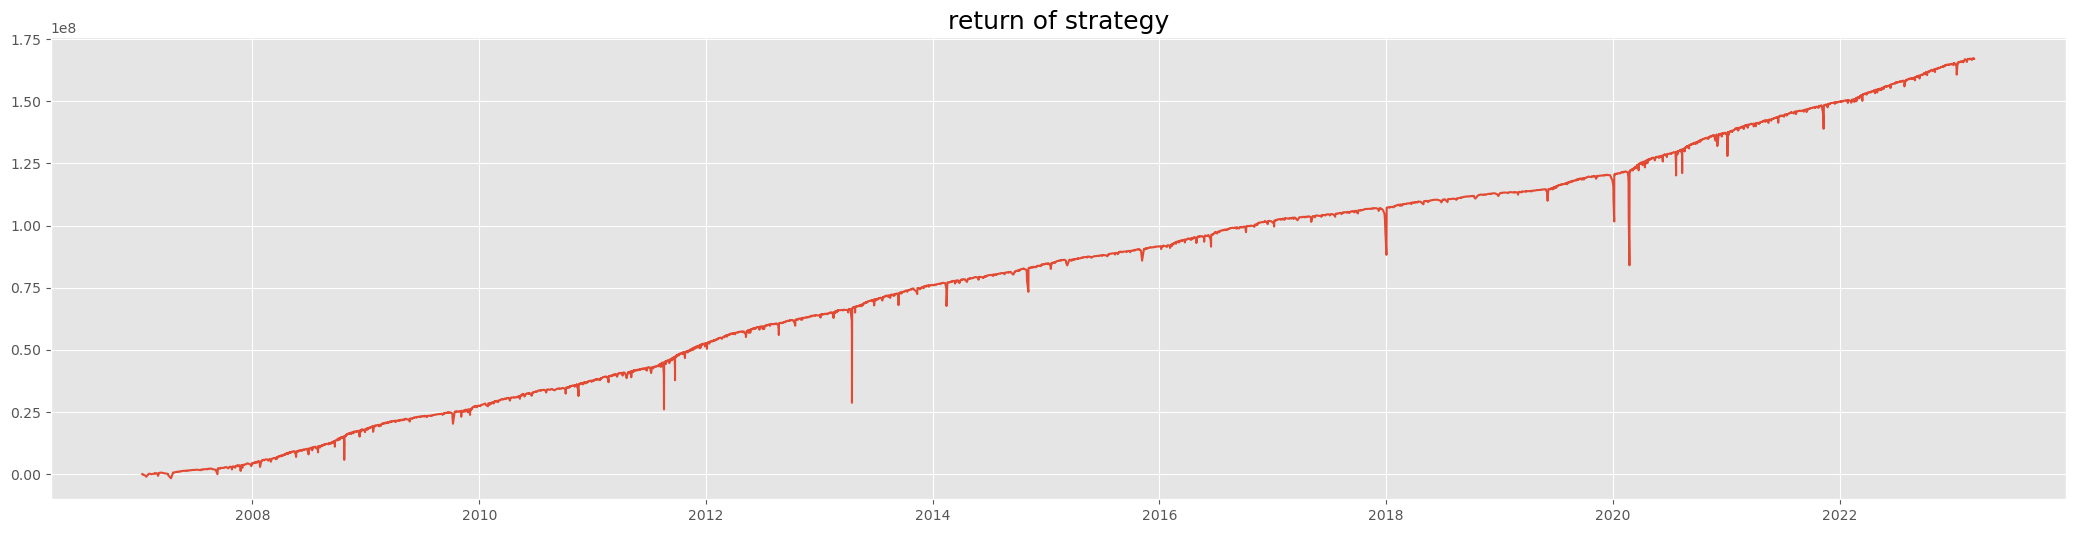

In [14]:
#Strategy performance
print('***** STRATEGY PERFORMANCE *****')
print('--------------------------------')
print('CAGR:', CAGR(strategy_results, df[0]), '%')
print('Sharpe ratio:', sharpe_ratio(strategy_results))
print('Maximum drawdown', max_drawdown(strategy_results), '% \n')
print('Number of trades:', len(str_profits + str_losses + str_be))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_be), '\n')
print('Winning percentage', (round(len(str_profits) / (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('ROI:', round(strategy_results['cum_res'][-1]) - account_size)
print('--------------------------------')
print('Average profitable trade:', round(sum(str_profits) / len(str_profits), 2))
print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
print('Max profitable trade:', round(max(str_profits), 2))
print('Max lossing trade:', round(min(str_losses), 2))

plt.figure(figsize = (26, 6))
plt.plot(strategy_results['cum_res'])
plt.title('return of strategy', fontsize = 18)

XAUUSD/XAUUSD_H4 - XAUUSD_H4 - PERFORMANCE
--------------------------------
Number of trades: 4532
Number of profits: 2265
Number of losses: 2266
Number of breakevens: 1 

Winning percentage 49.99 %
ROI: 167027780.74
--------------------------------
Average profitable trade: 345535.6
Average lossing trade: -271672.71
Max profitable trade: 37806465.16
Max lossing trade: -18903232.58
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    879
Mon    892
Sun     38
Thu    927
Tue    914
Wed    882
Name: result, dtype: int64


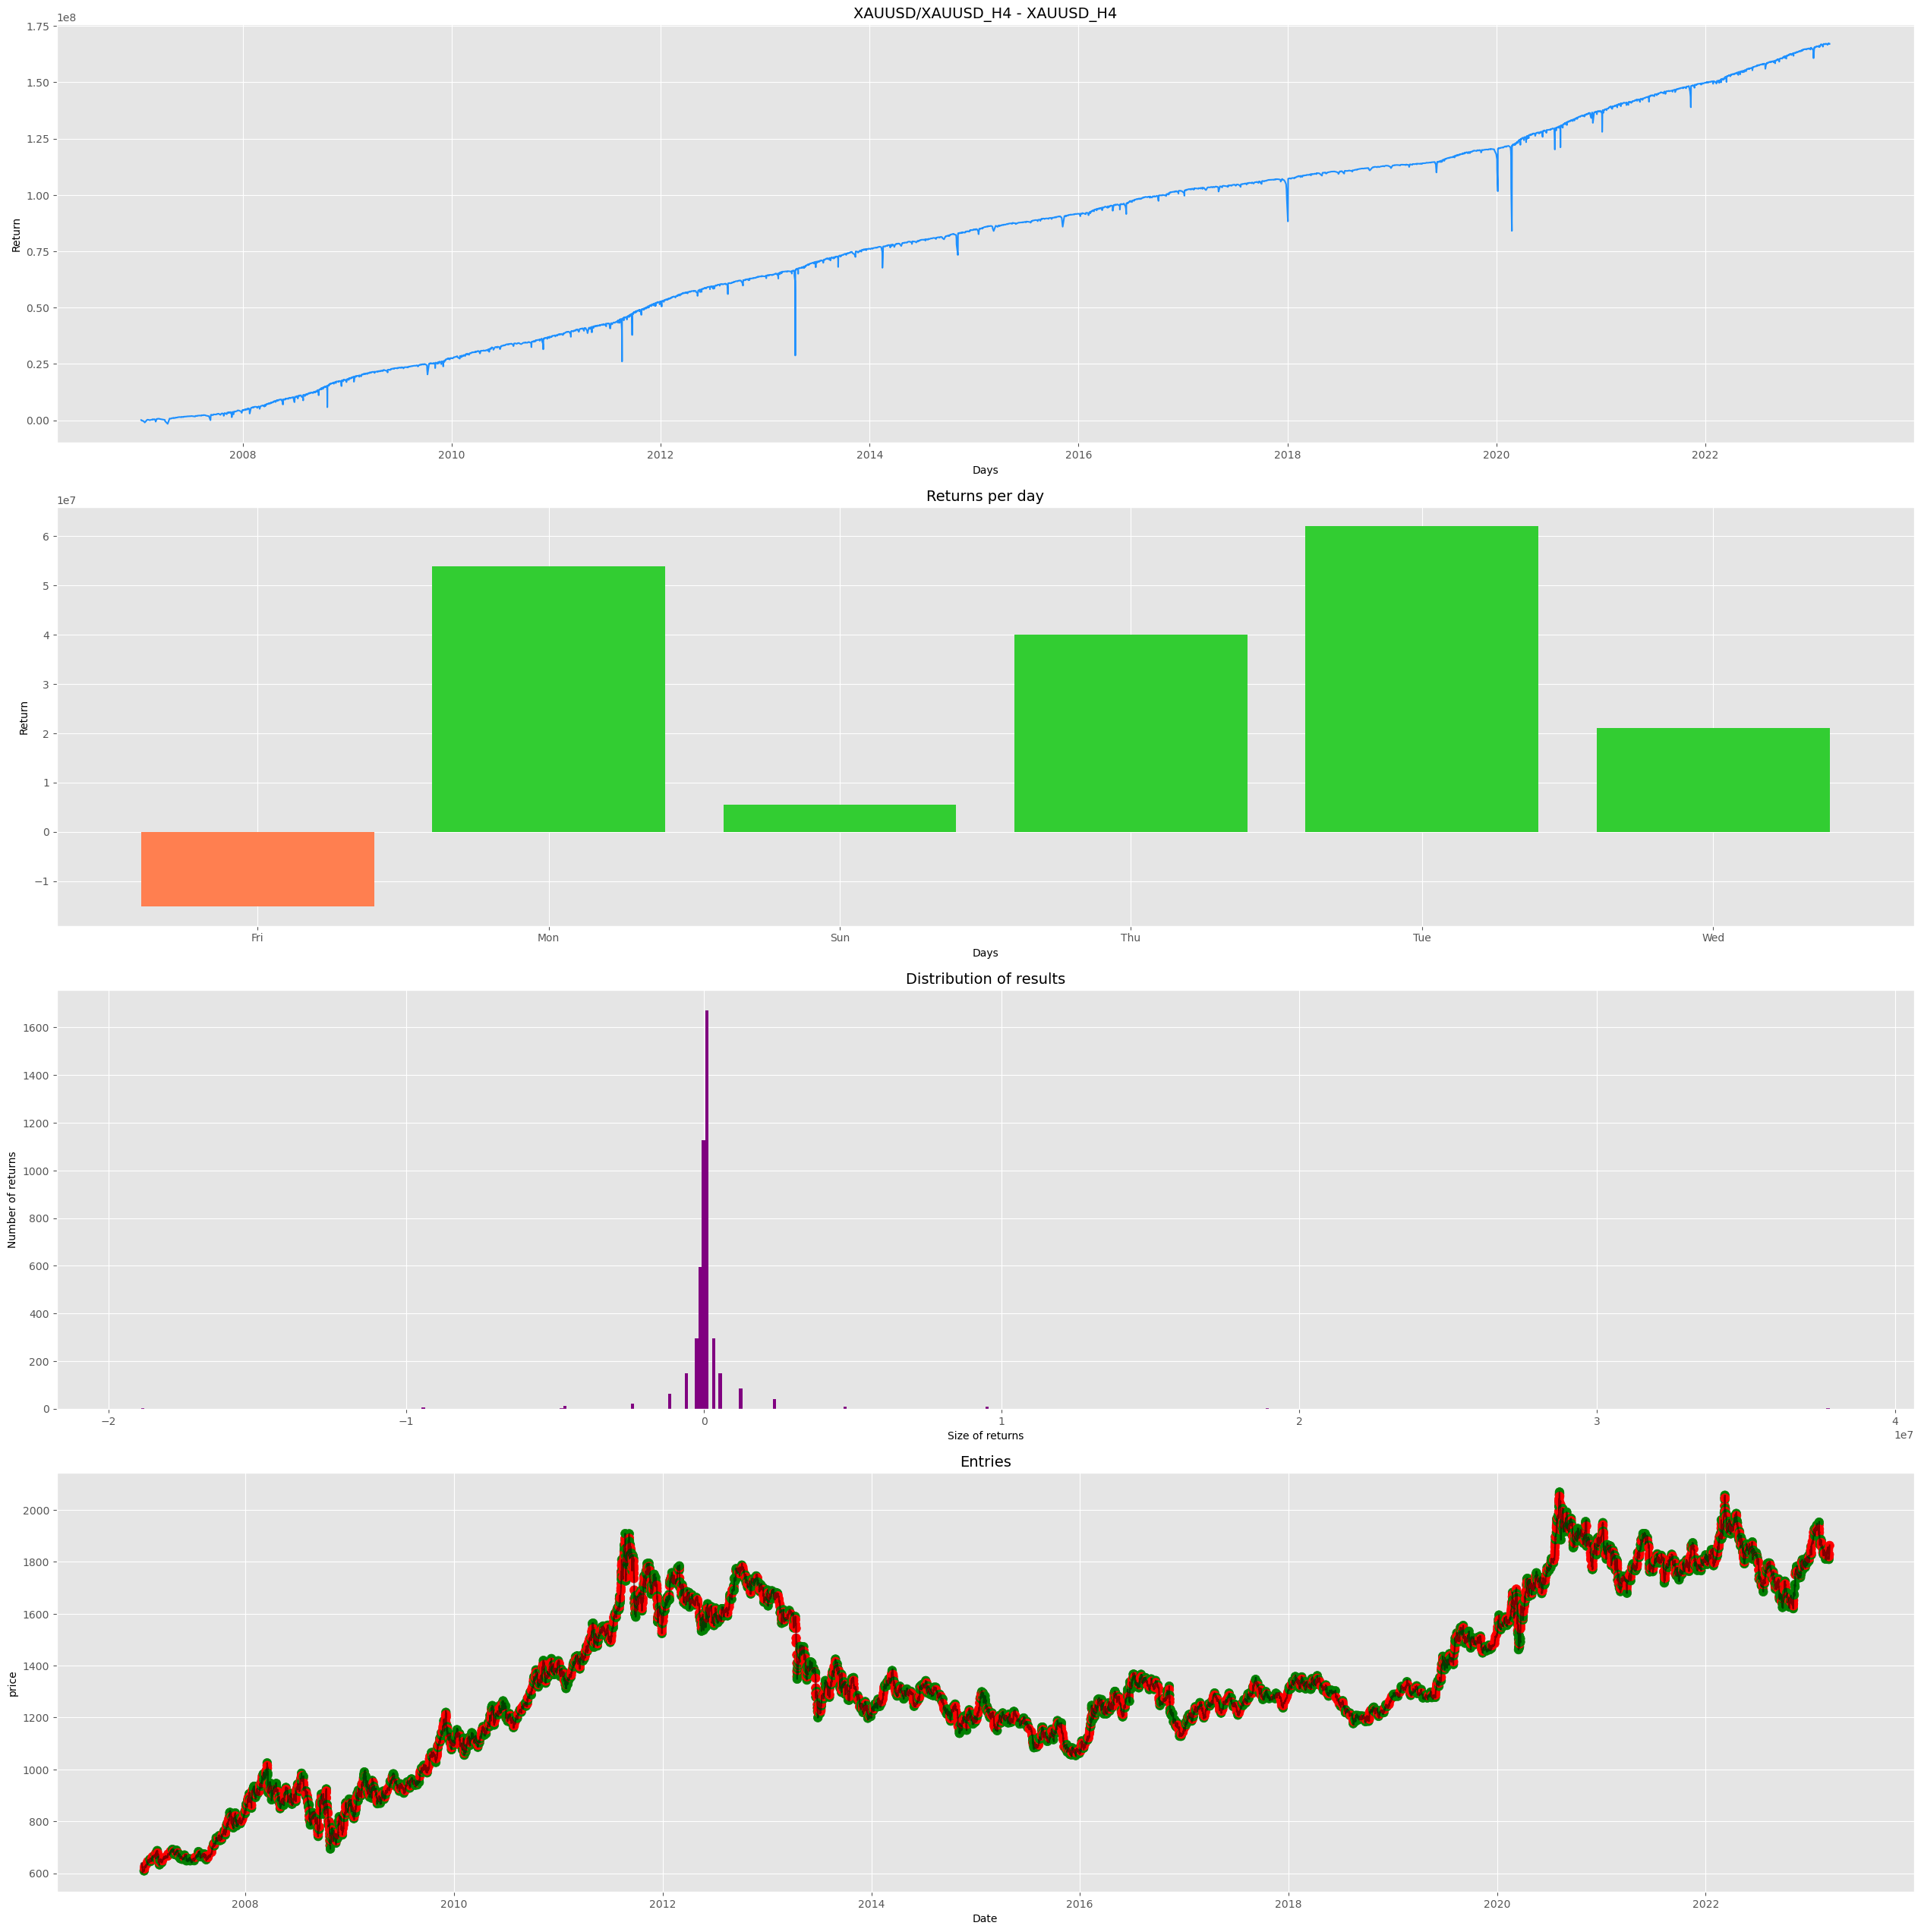

In [15]:
#performance for each pair
for pair in range(len(pairs_list)):
    print(pairs_list[pair], '- PERFORMANCE')
    print('--------------------------------')
    print('Number of trades:', len(profits[pair] + losses[pair] + be[pair]))
    print('Number of profits:', len(profits[pair]))
    print('Number of losses:', len(losses[pair]))
    print('Number of breakevens:', len(be[pair]), '\n')
    print('Winning percentage', (round(len(profits[pair]) / (len(profits[pair]) + len(losses[pair])) * 100, 2)), '%')
    print('ROI:', round(pairs_results[pair]['cum_res'][-1] - account_size, 2))
    print('--------------------------------')
    print('Average profitable trade:', round(sum(profits[pair]) / len(profits[pair]), 2))
    print('Average lossing trade:', round(sum(losses[pair]) / len(losses[pair]), 2))
    print('Max profitable trade:', round(max(profits[pair]), 2))
    print('Max lossing trade:', round(min(losses[pair]), 2))
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx \n')
    
    trades_per_day = pairs_results[pair].groupby('day_of_trade').count()['result']
    day_return = pairs_results[pair].groupby('day_of_trade').sum()['result']
    day_return_positive = day_return > 0
    positive_results = pairs_results[pair]['result'] > 0
    
    print('Number of trades per day \n', trades_per_day)
    
    fig, axes = plt.subplots(4, 1, figsize = (26, 26))
    fig.tight_layout(pad = 4)
    
    axes[0].plot(pairs_results[pair]['cum_res'], color = 'dodgerblue')
    axes[0].set_title(pairs_list[pair], fontsize = 14)
    axes[0].set_xlabel('Days')
    axes[0].set_ylabel('Return')
    
    axes[1].bar(day_return.keys(), height = day_return, color = day_return_positive.map({True: 'limegreen', False: 'coral'}))
    axes[1].set_title('Returns per day', fontsize = 14)
    axes[1].set_xlabel('Days')
    axes[1].set_ylabel('Return')
    
    axes[2].hist(pairs_results[pair]['result'], bins = 500, color = 'purple')
    axes[2].set_title('Distribution of results', fontsize = 14)
    axes[2].set_xlabel('Size of returns')
    axes[2].set_ylabel('Number of returns')
    
    axes[3].plot(df[pair]['Close'], color = 'black', alpha = 0.5)
    axes[3].scatter(pairs_results[pair].index, pairs_results[pair]['entry_price'], s = 70, color = positive_results.map({True: 'green', False: 'red'}))
    axes[3].set_title('Entries', fontsize = 14)
    axes[3].set_xlabel('Date')
    axes[3].set_ylabel('price')
    
    plt.show()